In [1]:
import pandas as pd

In [2]:
import h5py
import pywt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import get_ecg as ge
import read_ecg as re
#import features as ft


## The prediction data frame

In [3]:
dnn_annotations = pd.read_csv("./data/annotations/dnn.csv") #df as in Data Frame
print(dnn_annotations)

     Unnamed: 0  1dAVb  RBBB  LBBB  SB  AF  ST
0             0      0     0     0   0   0   0
1             1      0     0     1   0   0   0
2             2      0     0     0   0   0   0
3             3      0     0     0   0   0   0
4             4      0     0     0   0   0   0
..          ...    ...   ...   ...  ..  ..  ..
822         822      0     0     0   0   0   0
823         823      0     0     0   0   0   0
824         824      0     0     0   0   0   0
825         825      0     0     0   0   0   0
826         826      1     0     0   0   0   0

[827 rows x 7 columns]


In [4]:
dnn_annotations['SB'].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## The raw ECGs

In [5]:
def is_only_zero(li):
    return (np.sum(np.abs(li)<0.0001)==len(li))

print('is_only_zero([0,-1,1]) : '+str(is_only_zero([0,-1,1])))
print('is_only_zero([0.0000000001,-0.000000000003,0]) : '+str(is_only_zero([0.0000000001,-0.000000000003,0])))

is_only_zero([0,-1,1]) : False
is_only_zero([0.0000000001,-0.000000000003,0]) : True


In [6]:
def has_dead_lead(lili): #shape = (p,t)
    (p,t) = np.shape(lili)
    verdict = False
    for lead in range(p):
        verdict = verdict or is_only_zero(lili[lead])
    return verdict

#un signal temporel se lit en ligne, chaque ligne étant un 'lead' = une piste
test1 = np.array([[1,0,3],[0,0,1],[0,0,0]])
test2 = np.array([[1,2,3],[0,-1,1],[0,1,0]])
print('has_dead_lead(test1) : '+str(has_dead_lead(test1)))
print('has_dead_lead(test2) : '+str(has_dead_lead(test2)))

has_dead_lead(test1) : True
has_dead_lead(test2) : False


In [8]:
def get_clean_ecg(tracings_file="./data/ecg_tracings.hdf5"):
    with h5py.File(tracings_file, "r") as f:
        ecg_tracings = np.swapaxes(np.array(f['tracings']),1,2) #shape = (827,12,4096)
        bad_indexes = []
        for i in range(827):
            if has_dead_lead(ecg_tracings[i]):
                bad_indexes+=[i]
        ecg_tracings = np.delete(ecg_tracings, bad_indexes,0) #Isolate and delete the bad indexes
    return (bad_indexes,np.array([[re.delete_zeros(ecg[lead]) for lead in range(12)] for ecg in ecg_tracings])) #delete zeroes
(bad_indexes,table_ecg) = get_clean_ecg()
print(np.shape(table_ecg))
print(bad_indexes)

(813, 12)
[177, 251, 269, 321, 323, 385, 434, 446, 537, 542, 575, 601, 784, 790]


shape of table_ecg : (813, 12)


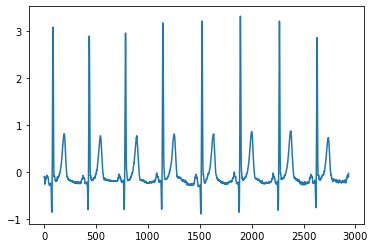

In [9]:
print('shape of table_ecg : '+str(np.shape(table_ecg)))
plt.plot(table_ecg[0][0])
plt.show()

In [10]:
list_ecg_0lead = table_ecg[:,0]
list_ecg_6lead = table_ecg[:,6]
list_ecg_7lead = table_ecg[:,7]
list_ecg_8lead = table_ecg[:,8]
list_ecg_9lead = table_ecg[:,9]
list_ecg_10lead = table_ecg[:,10]
list_ecg_11lead = table_ecg[:,11]

In [11]:
avgs_of_leads_0 = np.array([np.mean(list_ecg_0lead[k]) for k in range(np.shape(list_ecg_0lead)[0])])
print(len(avgs_of_leads_0))

813


In [12]:
dnn_annotations

,Unnamed: 0,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0
2,2,0,0,0,0,0,0
3,3,0,0,0,0,0,0
4,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...
822,822,0,0,0,0,0,0
823,823,0,0,0,0,0,0
824,824,0,0,0,0,0,0
825,825,0,0,0,0,0,0


In [13]:
dnn_annotations = dnn_annotations.drop(bad_indexes)

In [14]:
series={"moyenne0":avgs_of_leads_0,"moyenne1":avgs_of_leads_1}
pd.DataFrame(series)

NameError: name 'avgs_of_leads_1' is not defined

In [15]:
print(series["moyenne0"])

NameError: name 'series' is not defined

In [16]:
def delete_zeros(ecg):
    """Delete the first and the last occurences of zero in the ecg"""
    temp = ecg[np.where(np.abs(np.array(ecg)) > 10 ** (-6))[0][0]:]
    print(temp)
    return temp[:np.where(np.abs(np.array(temp)) > 10 ** (-6))[-1][-1]]

a=np.array([0,0,0,1,2,2,-1,0,0])
b=np.array([0,1,3,-2,1,0,0,0])
ab = np.array([a,b])
#delete_zeros(a)